# Convolutional Neural Network vs. Vision Transformer for Image Classification

## Setup

### Imports and Models

In [5]:
import numpy as np
import PIL
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import os
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, BitImageProcessor, BitForImageClassification
import time

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Both ViT and BiT models classify images into one of 1000 classes from ImageNet
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224').eval().to(DEVICE)
feature_extractor = BitImageProcessor.from_pretrained("google/bit-50")
bit_model = BitForImageClassification.from_pretrained("google/bit-50").eval().to(DEVICE)
print(DEVICE)

cuda


### Dataset

In [9]:
class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotations_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, annotations_file), 
            sep=',', header=0, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'), 
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image'] + '.JPEG'
        image = PIL.Image.open(os.path.join(self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

In [10]:
class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, 'val_annotations.txt'),
            sep='\t', header=None, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'),
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image']
        image = PIL.Image.open(os.path.join(
            self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")[
                'pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

### Functions and Loading Data

## Demo

In [11]:
# Returns the class index of the predicted class
def classify(model, processor, image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx


def load_data(annotations, directory=os.path.join('tiny_imagenet', 'val')):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.JPEG'):
                img = PIL.Image.open(os.path.join(root, file))
                data.append((img, ))
    return data

def load_annotations(directory=os.path.join('tiny_imagenet')):
    filepath = os.path.join(directory, 'val', 'val_annotations.txt')
    annotations = pd.read_csv(filepath, sep='\t', header=None) 
    annotations = annotations.loc[:, [0, 1]].rename(
        columns={0: 'filename', 1: 'wnid'})
    classes = pd.read_csv(os.path.join(directory, 'words.txt'), sep='\t', header=None).rename(columns={0: 'wnid', 1: 'class'})
    annotations['class'] = annotations['wnid'].map(classes.set_index('wnid')['class'])
    annotations.drop(columns=['wnid'], inplace=True)
    return annotations

annotations = load_annotations()

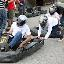

In [12]:
# imgs, labels = next(iter(dataloader))
data = TinyImageNetDataset(os.path.join('tiny_imagenet','val'))
img, label = data[0]
display(img)

In [13]:
vit_pred_idx = classify(vit_model, processor, img)
print("ViT prediction:", vit_model.config.id2label[vit_pred_idx])
bit_pred_idx = classify(bit_model, feature_extractor, img)
print("BiT prediction:", bit_model.config.id2label[bit_pred_idx])
ground_truth = annotations.loc[0 , 'class']
print("Ground truth:", ground_truth)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

## Analysis

### Tiny ImageNet
- subset of ImageNet-1k
- contains 10,000 images and only 200 of the original 1000 classes

In [14]:
annotations.nunique(0)

filename    10000
class         200
dtype: int64

In [15]:
data_dir = os.path.join('tiny_imagenet', 'val')
vit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=processor), batch_size=64)
bit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=feature_extractor), batch_size=64)

def get_accuracy(model, dataloader: DataLoader, device=torch.device('cpu')):
    correct = 0
    total = len(dataloader.dataset)
    start = time.time()
    with torch.no_grad():
        for imgs, labels in dataloader:
            labels = labels.to(device)
            imgs = imgs.to(device)
            outputs = model(imgs)
            pred = outputs.logits.argmax(-1)
            correct += (pred == labels).sum().item()
    return correct / total, time.time()-start
vit_accuracy, vit_time_taken = get_accuracy(vit_model, vit_dataloader, device=DEVICE)
bit_accuracy, bit_time_taken = get_accuracy(bit_model, bit_dataloader, device=DEVICE)
print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
print(f"Time taken: {vit_time_taken:.2f}s")
print()
print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
print(f"Time taken: {bit_time_taken:.2f}s")

ViT Accuracy: 62.07
Time taken: 47.64s

BiT Accuracy: 33.18
Time taken: 109.75s


In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def get_predictions(model, dataloader: DataLoader, device=torch.device('cpu')):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            preds = outputs.logits.argmax(-1)
            all_preds.append(preds.cpu().numpy())  # Move predictions to CPU for further processing
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

# Get predictions for both models
vit_predictions, vit_labels = get_predictions(vit_model, vit_dataloader, device=DEVICE)
bit_predictions, bit_labels = get_predictions(bit_model, bit_dataloader, device=DEVICE)

# Compute confusion matrices for both models
cm_vit = confusion_matrix(vit_labels, vit_predictions)
cm_bit = confusion_matrix(bit_labels, bit_predictions)

# Get unique labels from the true labels
unique_labels = np.unique(vit_labels)  # Using vit_labels, as an example

class_names = [f'class_{label}' for label in unique_labels]  # Replace with actual class names if available



[573 149 651 435 876 850 786 440 779 318 354 954 303 906 149 746 185 873
 817 652]
[573 758 760 435 435 850 786 440 779 311 842 954 311 655 145 462 286 873
 817 652]


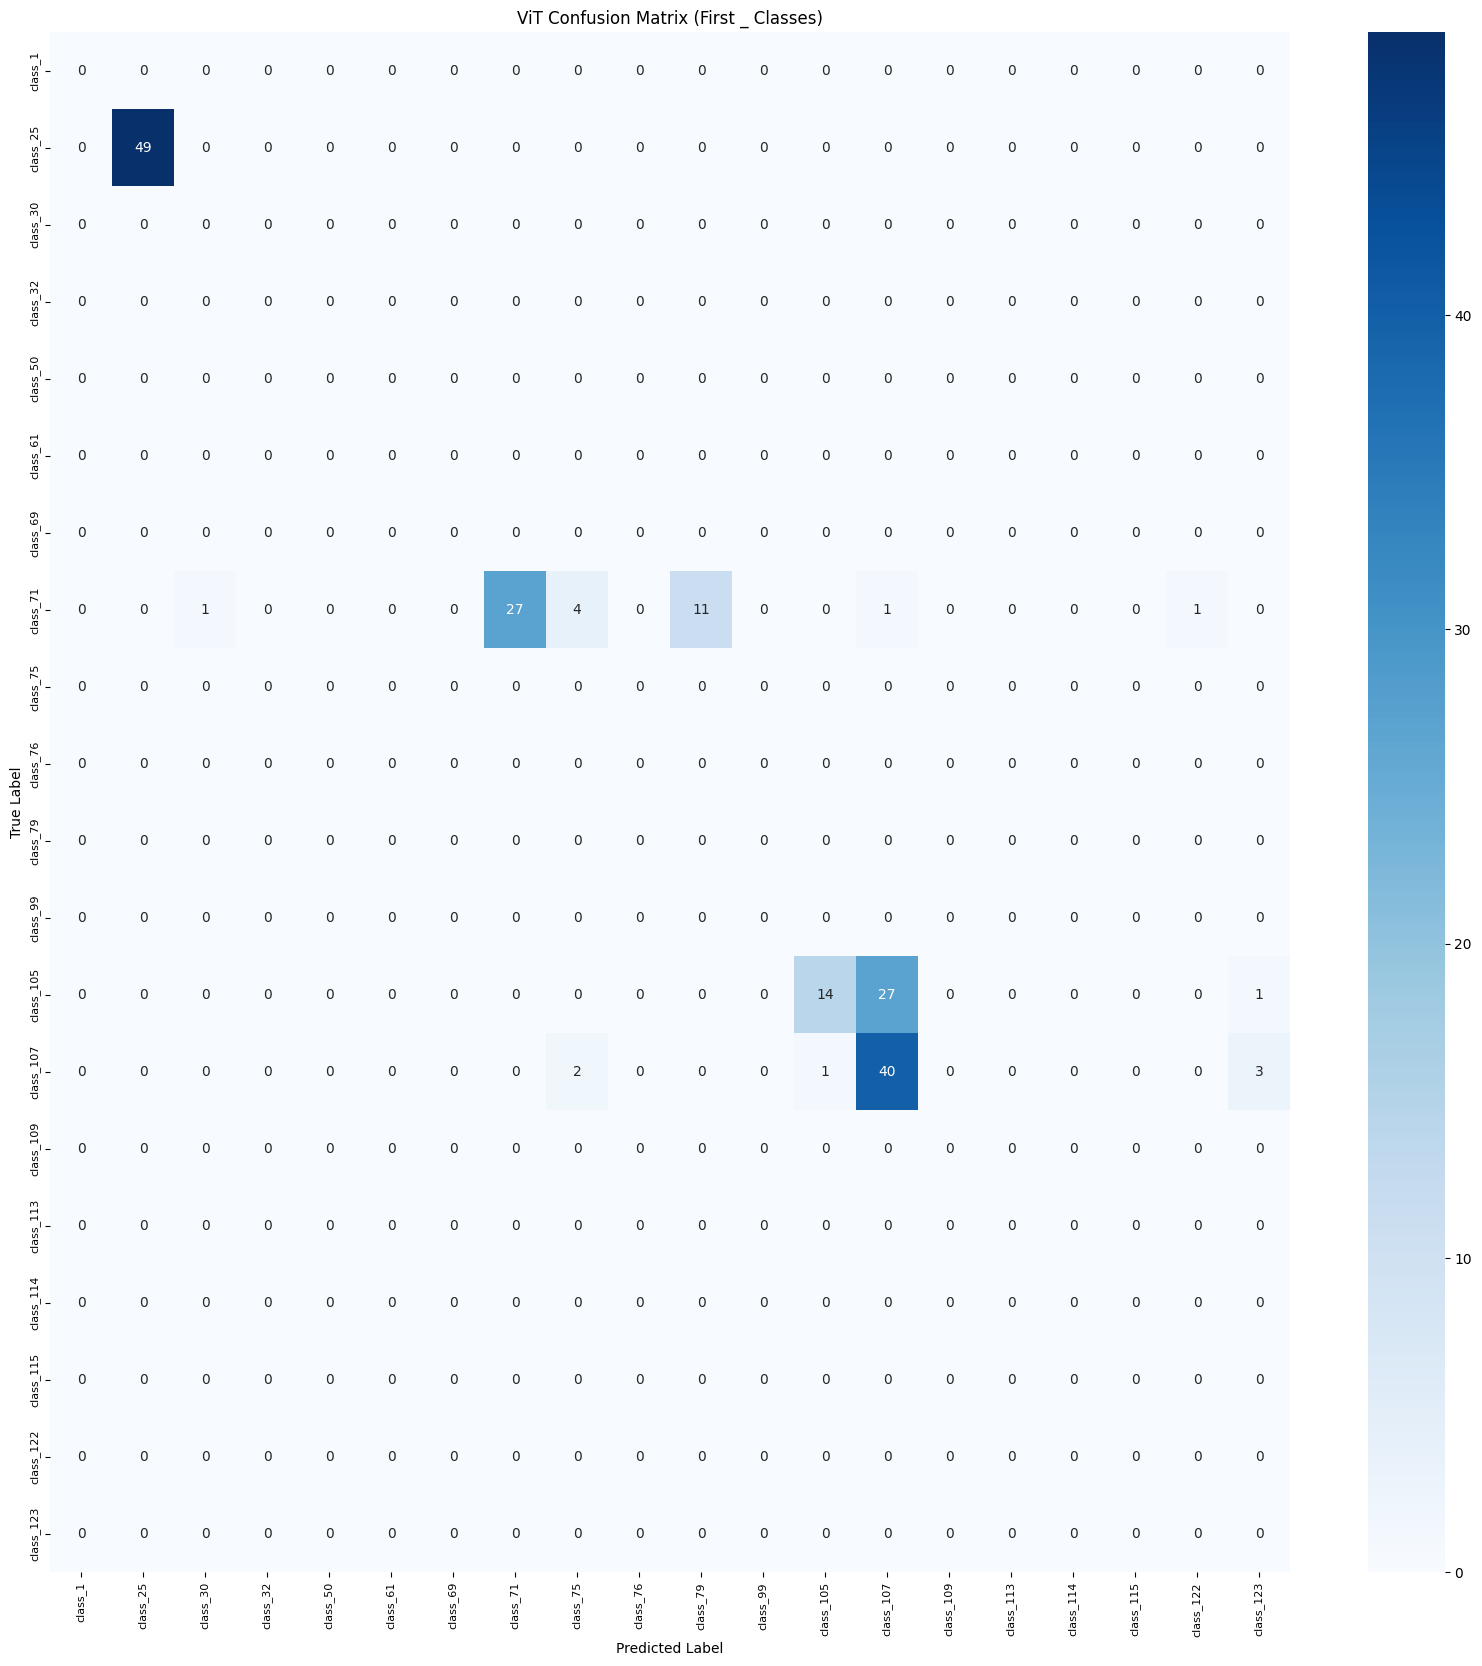

In [ ]:
# Number of classes to plot
# Load the confusion matrix data
import pickle
def load_confusion_matrix_data(filename):
    with open(filename, 'rb') as f:
        preds, labels, cm = pickle.load(f)
    return preds, labels, cm

# Example: Load confusion matrix data for ViT and BiT
vit_preds, vit_labels, cm_vit = load_confusion_matrix_data('vit_cm_data.pkl')

# Get unique labels from the true labels
unique_labels = np.unique(vit_labels)  # Using vit_labels, as an example

# Assuming you have the class-to-label mapping, you can retrieve the names
# For demonstration, here we create dummy names as class_{i} (you can replace them with actual class names)
class_names = [f'class_{label}' for label in unique_labels]  # Replace with actual class names if available
num_classes_to_plot = 20

# Select the first 5 classes from the confusion matrix
cm_vit_filtered = cm_vit[:num_classes_to_plot, :num_classes_to_plot]

# Plot confusion matrix for ViT with reduced font size for labels
plt.figure(figsize=(20, 20))
sns.heatmap(cm_vit_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:num_classes_to_plot], yticklabels=class_names[:num_classes_to_plot])
plt.title('ViT Confusion Matrix (First _ Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


print(vit_preds[:20])
print(vit_labels[:20])

In [77]:
import pickle
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

def save_confusion_matrix_data(model, dataloader, device, filename):
    # Get predictions
    preds, labels = get_predictions(model, dataloader, device=device)

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Save confusion matrix data
    with open(filename, 'wb') as f:
        pickle.dump((preds, labels, cm), f)

# Example: Save confusion matrix data for ViT and BiT
save_confusion_matrix_data(vit_model, vit_dataloader, device=DEVICE, filename='vit_cm_data.pkl')
save_confusion_matrix_data(bit_model, bit_dataloader, device=DEVICE, filename='bit_cm_data.pkl')


KeyboardInterrupt: 

In [18]:
import json
import os

# Check if the JSON file already exists
file_path = 'model_results.json'

# Initialize the results dictionary
results = {
    'vit_accuracy': vit_accuracy,
    'vit_time_taken': vit_time_taken,
    'bit_accuracy': bit_accuracy,
    'bit_time_taken': bit_time_taken
}

# If the file exists, load the previous results
if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        stored_results = json.load(f)
    
    # Compare and update if necessary
    if vit_accuracy > stored_results.get('vit_accuracy', 0):
        stored_results['vit_accuracy'] = vit_accuracy
        stored_results['vit_time_taken'] = vit_time_taken
        
    if bit_accuracy > stored_results.get('bit_accuracy', 0):
        stored_results['bit_accuracy'] = bit_accuracy
        stored_results['bit_time_taken'] = bit_time_taken

    # If no updates were made, don't overwrite the file
    if stored_results != results:
        with open(file_path, 'w') as f:
            json.dump(stored_results, f)
        print(f"Results updated in {file_path}")
    else:
        print("No updates to the results.")

else:
    # If the file doesn't exist, save the initial results
    with open(file_path, 'w') as f:
        json.dump(results, f)
    print(f"Results saved to {file_path}")


No updates to the results.


In [ ]:
import pickle
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

def save_confusion_matrix_data(model, dataloader, device, filename):
    # Get predictions
    preds, labels = get_predictions(model, dataloader, device=device)

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Save confusion matrix data
    with open(filename, 'wb') as f:
        pickle.dump((preds, labels, cm), f)

# Example: Save confusion matrix data for ViT and BiT
save_confusion_matrix_data(vit_model, vit_dataloader, device=DEVICE, filename='vit_cm_data.pkl')
save_confusion_matrix_data(bit_model, bit_dataloader, device=DEVICE, filename='bit_cm_data.pkl')


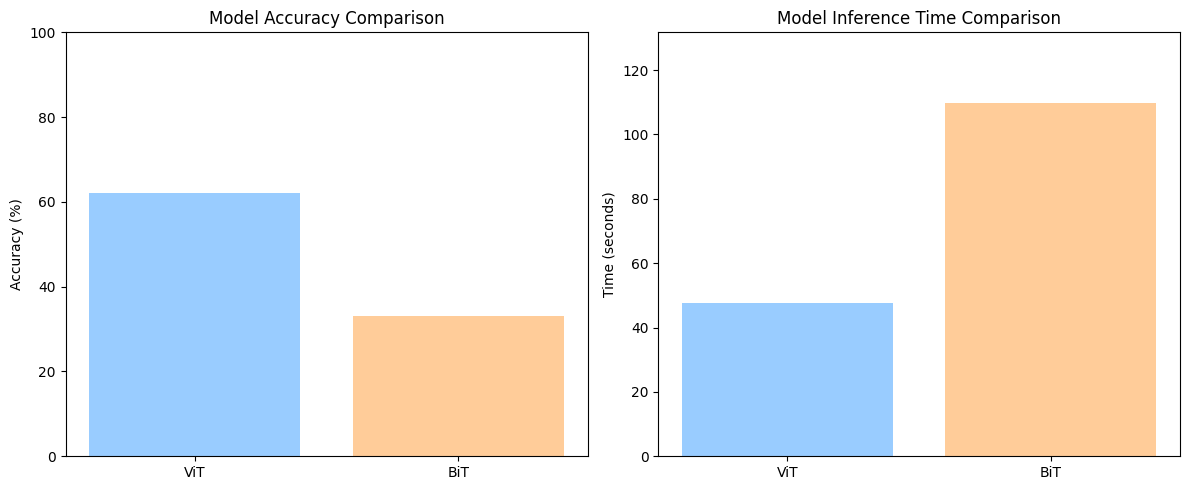

In [23]:
# File path where the results are stored
file_path = 'model_results.json'

# Initialize default values in case the file does not exist
results = {
    'vit_accuracy': 0,
    'vit_time_taken': 0,
    'bit_accuracy': 0,
    'bit_time_taken': 0
}

# Retrieve results from the file if it exists
if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        results = json.load(f)

# Extract accuracy and time taken from the file
vit_accuracy = results.get('vit_accuracy', 0)
vit_time_taken = results.get('vit_time_taken', 0)
bit_accuracy = results.get('bit_accuracy', 0)
bit_time_taken = results.get('bit_time_taken', 0)

# Model names
models = ['ViT', 'BiT']

# Accuracy and time taken values
accuracies = [vit_accuracy * 100, bit_accuracy * 100]
times_taken = [vit_time_taken, bit_time_taken]

# Create a figure and axis
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Lighter colors for the bars using hex values
light_blue = '#99CCFF'  # Lighter shade of blue
light_orange = '#FFCC99'  # Lighter shade of orange

# Accuracy Plot
ax[0].bar(models, accuracies, color=[light_blue, light_orange])
ax[0].set_title('Model Accuracy Comparison')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_ylim(0, 100)

# Time Taken Plot
ax[1].bar(models, times_taken, color=[light_blue, light_orange])
ax[1].set_title('Model Inference Time Comparison')
ax[1].set_ylabel('Time (seconds)')
ax[1].set_ylim(0, max(times_taken) * 1.2)  # Add some space for better visibility

# Display the plots
plt.tight_layout()
plt.show()


### ImageNet
- validation set: 50,000 images split among 1000 classes
- we use the validation set because the test set does not have publically-available ground-truth labels
    - but we still want to avoid using images that the models were trained on

In [ ]:
data_dir = 'imagenet'
annotations_file = 'LOC_val_solution.csv'
vit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=processor), batch_size=64)
bit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=feature_extractor), batch_size=64)


def get_accuracy(model, dataloader):
    correct = 0
    total = len(dataloader.dataset)
    start = time.time()
    with torch.no_grad():
        for imgs, labels in dataloader:
            outputs = model(imgs)
            pred = outputs.logits.argmax(-1)
            correct += (pred == labels).sum().item()
    return correct / total, time.time()-start

vit_accuracy, vit_time_taken = get_accuracy(vit_model, vit_dataloader)
bit_accuracy, bit_time_taken = get_accuracy(bit_model, bit_dataloader)
print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
print(f"Time taken: {vit_time_taken:.2f}s")
print()
print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
print(f"Time taken: {bit_time_taken:.2f}s")

ViT Accuracy: 85.94
BiT Accuracy: 84.90
